In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from nilearn.datasets import fetch_atlas_talairach, fetch_atlas_aal, load_mni152_template
from nilearn.image import load_img
import numpy as np
from captum.attr import LayerAttribution
import torch

from sage.xai.utils import _mni, MNI_SHAPE
from sage.xai.nilearn_plots import plot_brain, plot_glass_brain, plot_overlay
from sage.xai.atlas import get_atlas

UNIT_Y = 25 / 116

In [12]:
atlas = get_atlas(atlas_name="oxford")

/home/1pha/codespace/brain-age-prediction/sage/xai/utils.py:104: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  arr = torch.tensor(arr)


AssertionError: # Labels and indices should be same: len(indices)=94, len(labels)=97

(<nilearn.plotting.displays._projectors.OrthoProjector at 0x7f8c7ec66ce0>,
 None)

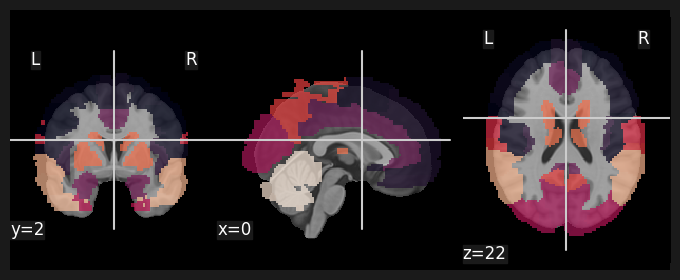

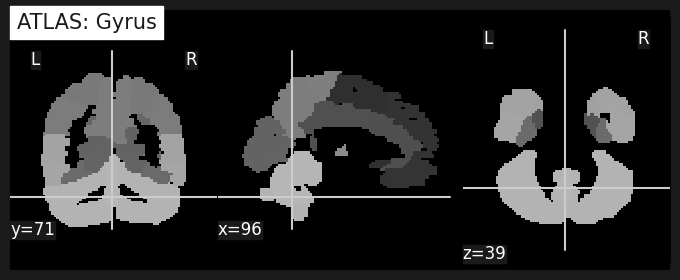

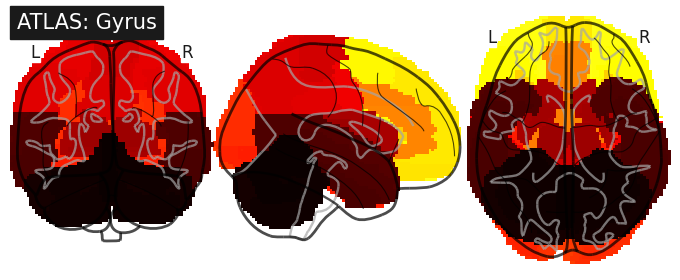

In [11]:
plot_overlay(atlas.array)
plot_brain(atlas.array, title="ATLAS: Gyrus")
plot_glass_brain(atlas.array, title="ATLAS: Gyrus")

In [41]:
template_img = load_mni152_template()

template_data, template_affine = template_img.get_fdata(), template_img.affine

moving_data, age = open_h5("biobank/part1/1000126_20252_2_0.h5")
moving_img = _mni(moving_data)
moving_affine = template_affine.copy()

In [42]:
import nibabel as nib
from dipy.align.imaffine import (
    AffineMap,
    AffineRegistration,
    MutualInformationMetric,
    transform_centers_of_mass,
)
from dipy.align.imwarp import SymmetricDiffeomorphicRegistration
from dipy.align.metrics import CCMetric
from dipy.align.transforms import (
    AffineTransform3D,
    RigidTransform3D,
    TranslationTransform3D,
)
from dipy.viz import regtools
from nilearn.datasets import load_mni152_template

In [43]:
# 00. Set Params
# The mismatch metric
nbins = 32
sampling_prop = None
metric = MutualInformationMetric(nbins, sampling_prop)

# The optimization strategy
level_iters = [10, 10, 5]
sigmas = [3.0, 1.0, 0.0]
factors = [4, 2, 1]

In [45]:
# 01. Define Affine Registration
affreg = AffineRegistration(
    metric=metric, level_iters=level_iters, sigmas=sigmas, factors=factors
)

c_of_mass = transform_centers_of_mass(
    template_data, template_affine, moving_data, moving_affine
)
starting_affine = c_of_mass.affine

In [46]:
# 02. Registration
# 02-1. Translation
print("1. Translation Optimization")
transform = TranslationTransform3D()
params0 = None
translation = affreg.optimize(
    template_data,
    moving_data,
    transform,
    params0,
    template_affine,
    moving_affine,
    starting_affine=starting_affine,
)

1. Translation Optimization
Optimizing level 2 [max iter: 10]
Optimizing level 1 [max iter: 10]
Optimizing level 0 [max iter: 5]


In [ ]:
# 02-2. Rigid
print("2. Rigid Optimization")
transform = RigidTransform3D()
rigid = affreg.optimize(
    template_data,
    moving_data,
    transform,
    params0,
    template_affine,
    moving_affine,
    starting_affine=translation.affine,
)

In [ ]:
# 02-3. Affine
print("3. Affine Optimization")
transform = AffineTransform3D()
# Bump up the iterations to get an more exact fit
affreg.level_iters = [1000, 1000, 100]
affine = affreg.optimize(
    template_data,
    moving_data,
    transform,
    params0,
    template_affine,
    moving_affine,
    starting_affine=rigid.affine,
)

In [ ]:
from dipy.viz import regtools
def plot_transform_overlay(static: np.ndarray, moving: np.ndarray, translation):
    if not isinstance(static, np.ndarray):
        static = translation.transform(static)
    regtools.overlay_slices(static, moving, None, 0, "Template", "Transformed")
    regtools.overlay_slices(static, moving, None, 1, "Template", "Transformed")
    regtools.overlay_slices(static, moving, None, 2, "Template", "Transformed")

In [ ]:
plot_transform_overlay(static=template_data, moving=translation)

/home/1pha/.conda/envs/age/lib/python3.10/site-packages/nilearn/_utils/niimg.py:62: UserWarning: Non-finite values detected. These values will be replaced with zeros.
  warn(


(<nilearn.plotting.displays._slicers.OrthoSlicer at 0x7f8c7c2880d0>, None)

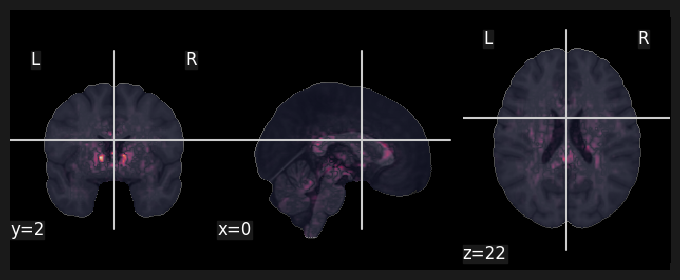

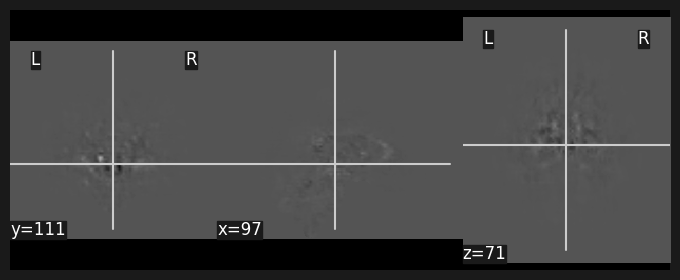

In [14]:
mask_path = "assets/weights/resnet10t-aug/no-mask/ig-total/attrs.npy"
saliency = np.load(mask_path)

plot_overlay(saliency)
plot_brain(saliency)

In [15]:
from sage.data.dataloader import open_h5

In [22]:
arr, age = open_h5("biobank/part1/1000126_20252_2_0.h5")
arr, age = open_h5("biobank/part1/2613556_20252_2_0.h5")

(<nilearn.plotting.displays._slicers.OrthoSlicer at 0x7f8c747eb340>, None)

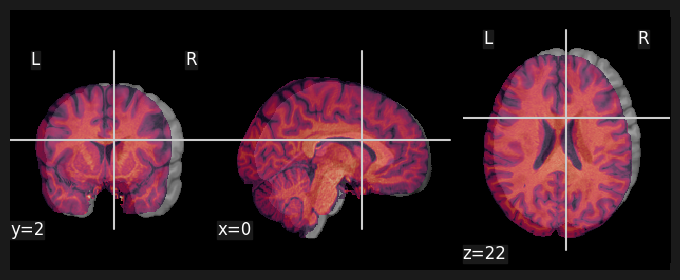

In [23]:
plot_overlay(arr)

(<nilearn.plotting.displays._slicers.OrthoSlicer at 0x7f8c74752050>, None)

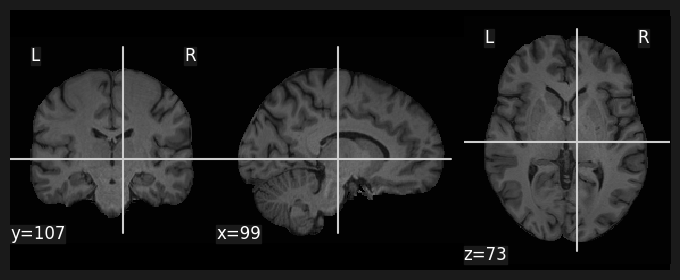

In [24]:
plot_brain(arr)

In [66]:
value_by_parts = {}
for label, index in zip(atlas.labels, atlas.indices):

    mask = atlas.array == int(index)
    num_voxels_roi = len(mask.nonzero()[0])
    value = np.nansum(np.abs(saliency[mask])) / num_voxels_roi
    value_by_parts[label] = value

In [69]:
from collections import defaultdict
def sum_regions(xai_dict: dict):
    reduced = defaultdict(list)
    for roi in xai_dict.keys():
        r_roi = roi.split("_")[0]
        reduced[r_roi].append(xai_dict[roi])
    
    for r_roi in reduced.keys():
        reduced[r_roi] = np.mean(reduced[r_roi])
    return reduced

In [81]:
def brain_barplot(xai_dict: dict, title: str = None):
    fig, ax = plt.subplots(figsize=(12, UNIT_Y * len(xai_dict)))
    ax.set_title(title or "")
    sns.barplot(
        x=list(xai_dict.values()),
        y=list(xai_dict.keys()),
        ax=ax
    )

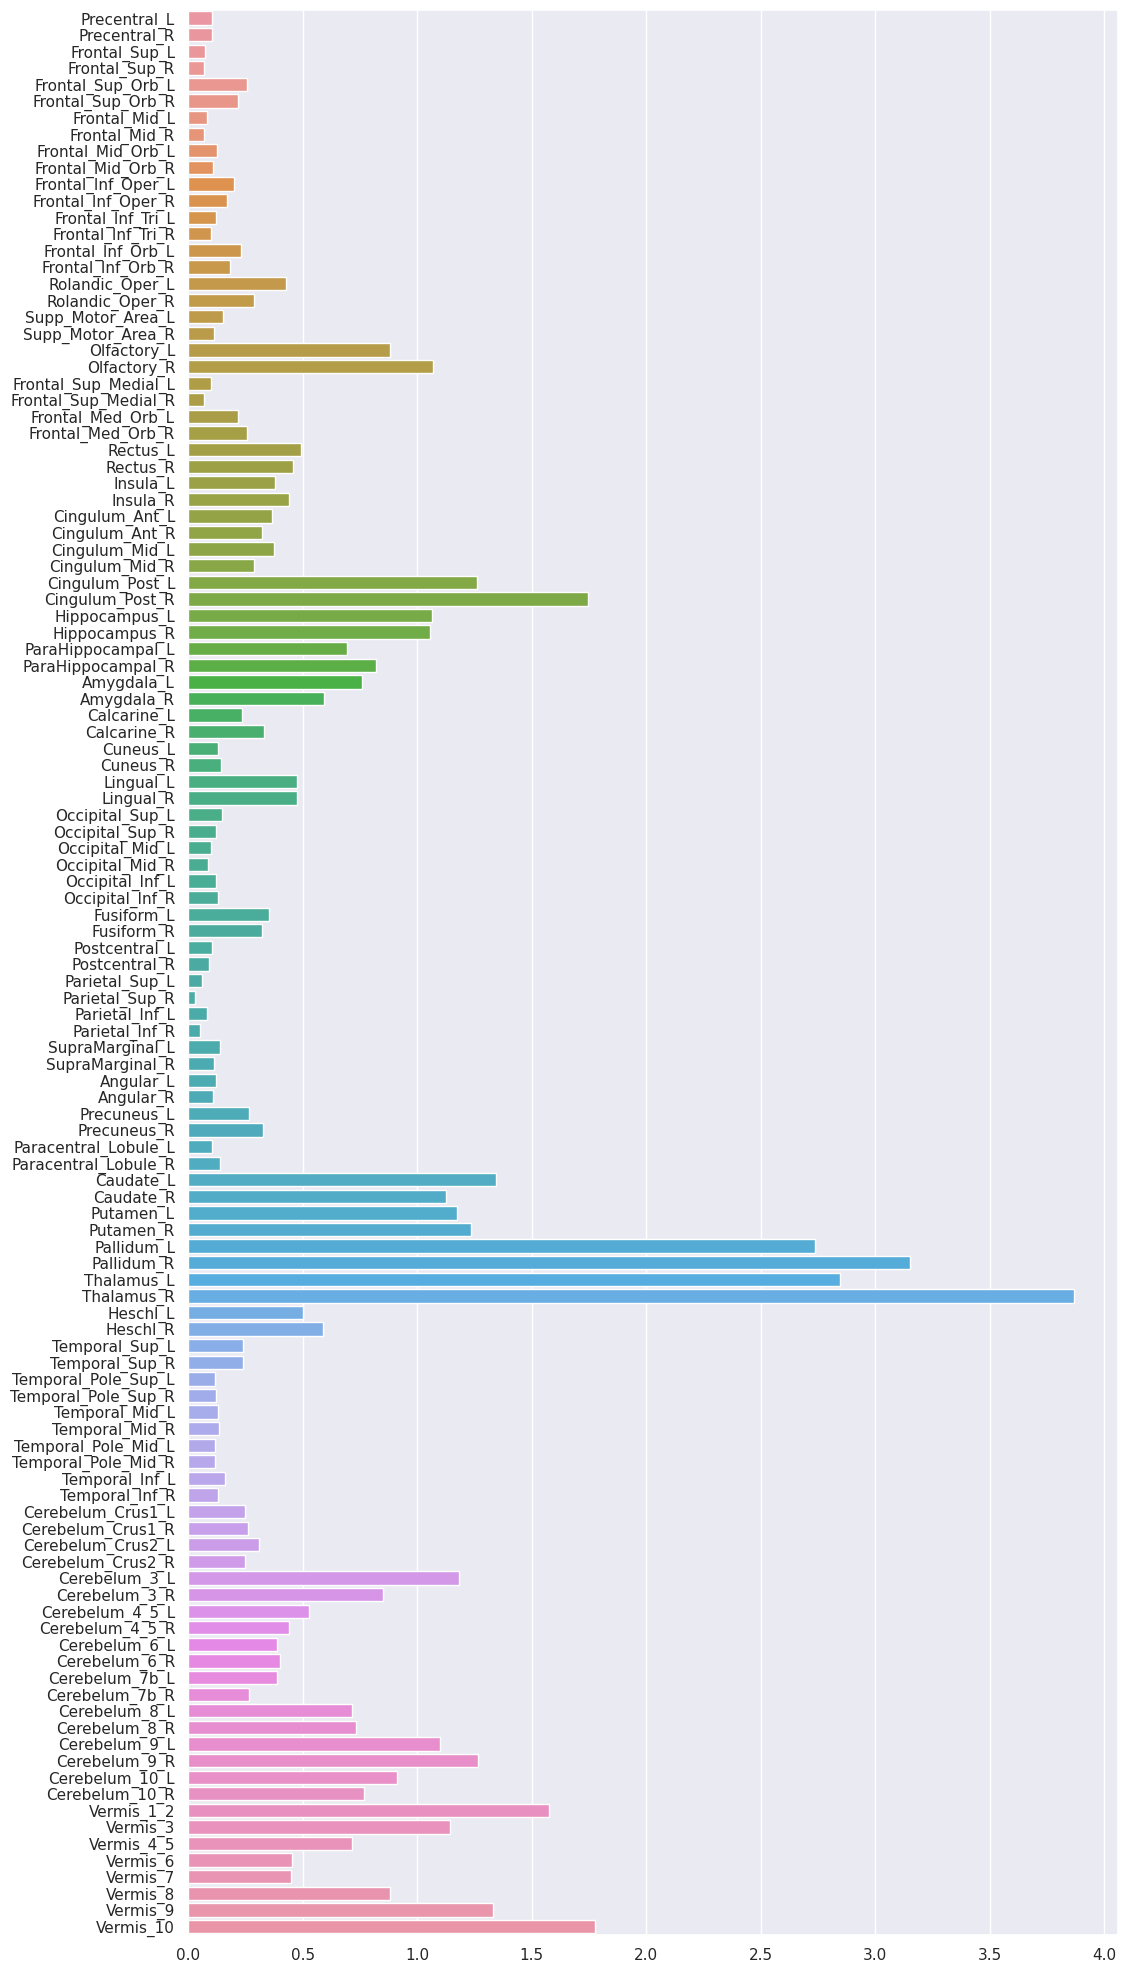

In [82]:
brain_barplot(xai_dict=value_by_parts)

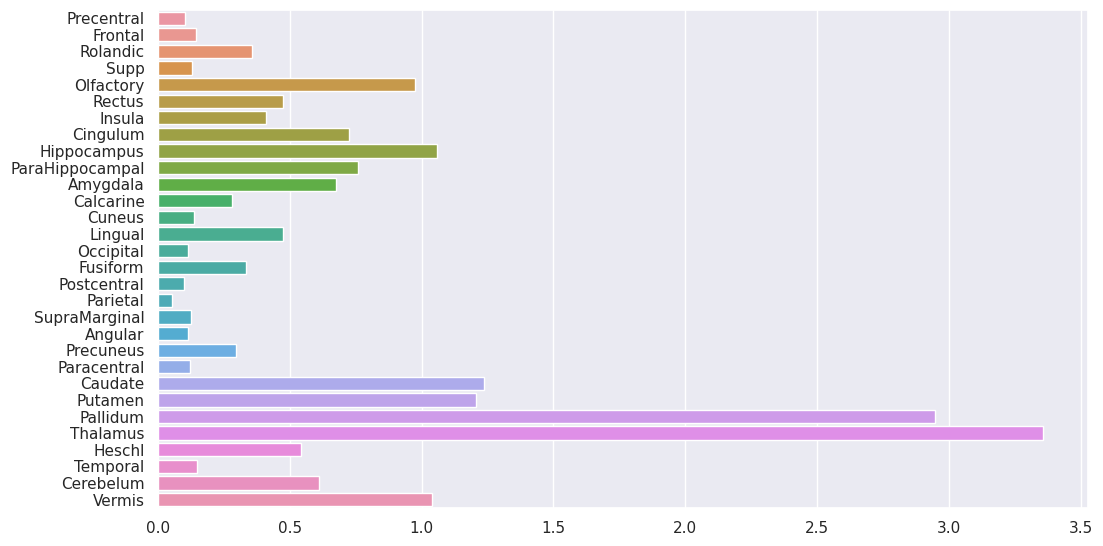

In [83]:
sr = sum_regions(xai_dict=value_by_parts)
brain_barplot(xai_dict=sr)